In [3]:
# from torchvision import datasets, transforms
# def build_dataset():
#     train_dataset = datasets.CIFAR10(
#         root="../data",                                
#         train=True,
#         transform=transforms.ToTensor(),
#         download=True)
#     test_dataset = datasets.CIFAR10(
#         root="../data", 
#         train=False,
#         transform=transforms.ToTensor(),
#         download=True)
#     train_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=64, 
#         shuffle=True)
#     test_loader = torch.utils.data.DataLoader(
#         test_dataset,
#         batch_size=64, 
#         shuffle=True)
#     return train_dataset, test_dataset, train_loader, test_loader
# train_dataset = datasets.VOCDetection("../data", image_set="train", 
#                                       transform=transforms.ToTensor(), 
#                                       download=True)
# train_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=64, 
#         shuffle=True)

In [1]:
import torch
import torch.nn as nn
from torchxai.base import XaiBase, XaiHook, XaiModel
from collections import OrderedDict
from src.models import CnnMnist, ResNetMnist, ResNetMnistCBAM
import matplotlib.pyplot as plt

In [2]:
model = CnnMnist()
model2 = ResNetMnist()
model3 = ResNetMnistCBAM()
x = torch.randn(1, 1, 28, 28)
print("model")
o = model(x)
print(o.size())
print("model2")
o = model2(x)
print(o.size())
print("model3")
o = model3(x)
print(o.size())

model
torch.Size([1, 10])
model2
torch.Size([1, 10])
model3
torch.Size([1, 10])


---

In [3]:
from torchxai.model import GradCAM, DeconvNet, VanillaGrad, InputGrad, GuidedGrad, LRP
import matplotlib.pyplot as plt

In [4]:
kwargs_packs = {
    "mnist": {
        "gradcam": {
            "cnn": dict(layers_name=None, norm_mode=1),
            "resnet": dict(layers_name="relu_last", norm_mode=1),
            "resnetcbam": dict(layers_name="relu_last", norm_mode=1)
        },
        "guidedgrad": {
            "cnn": dict(module_name="convs", act=nn.ReLU),
            "resnet": dict(module_name=["resnet_layers", "relu"], act=nn.ReLU),
            "resnetcbam": dict(module_name=["resnet_layers", "relu"], act=nn.ReLU)
        },
        "relavance": {
            "cnn": dict(use_rho=False)
        },
        "deconv": {
            "cnn": dict(module_name="convs")
        }, 
        "vanillagrad": None, 
        "inputgrad": None
    },
    "cifar10": {
        "gradcam": {
            "resnet": dict(layers_name="relu_last", norm_mode=3),
            "resnetcbam": dict(layers_name="relu_last", norm_mode=3)
        },
        "guidedgrad": {
            "resnet": dict(module_name=["resnet_layers", "relu"], act=nn.ReLU),
            "resnetcbam": dict(module_name=["resnet_layers", "relu"], act=nn.ReLU)
        },
        "vanillagrad": None, 
        "inputgrad": None
    }
}

def get_kwargs(data_type, a_type, m_type, kwargs_packs):
    pre_kwargs = kwargs_packs[data_type].get(a_type)
    if pre_kwargs is not None:
        kwargs = pre_kwargs.get(m_type)
    else:
        kwargs = {"<none>": None}
    return kwargs

In [5]:
data_type = "mnist"
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])

## GradCAM

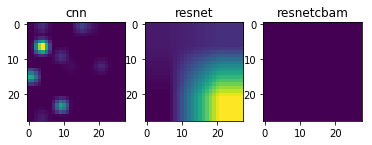

In [6]:
figure, axes = plt.subplots(1, 3)
a_type = "gradcam"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    gradcam_model = GradCAM(m, **kwargs)
    gradcam = gradcam_model.get_attribution(x, targets)
    ax.imshow(gradcam.squeeze())
    ax.set_title(m_type)
plt.show()

## GuidedGrad

In [61]:
class GuidedReLU(XaiHook):
    """GuidedReLU"""
    def __init__(self, module):
        super(GuidedReLU, self).__init__(module)
        self.register_hook(backward=False)
        self.register_hook(backward=True, hook_fn=self.b_hook)

    def b_hook(self, m, i, o):
        """
        backward hook
        i: (input,) -> backward output
        o: (output,) -> backward input
        """
        deconv_grad = o[0].clamp(min=0)  # o: backward input
        forward_output = self.o
        forward_mask = forward_output.ne(0.0).type_as(forward_output)
        grad_in = deconv_grad * forward_mask
        return grad_in
    
class GuidedGrad(XaiModel):
    """GuidedGrad"""
    def __init__(self, model, module_name=None, act=nn.ReLU, **kwargs):
        """
        """
        super(GuidedGrad, self).__init__(model)
        self.act = act
        if not isinstance(module_name, list):
            module_name = [module_name]
        self.all_hooks = []
        for n_name in module_name:
            self.register_guided_hooks(n_name)

    def register_guided_hooks(self, n_name):
        modules = self.model._modules[n_name]
        if isinstance(modules, nn.Sequential):
            for i, layer in enumerate(modules):
                if isinstance(layer, self.act):
                    # change layer to Guided Layer
                    modules[i] = GuidedReLU(layer)
                    self.all_hooks.append(modules[i])
        else:
            if isinstance(modules, self.act):
                self.model._modules[n_name] = GuidedGrad(modules)


    def get_attribution(self, x, targets):
        x.requires_grad_(True)
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(False)
        return x_grad

In [62]:
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    
    if m_type == "resnet":
        break

In [63]:
a = GuidedGrad(m, **kwargs)

KeyError: None

TypeError: __init__() missing 1 required positional argument: 'module_name'

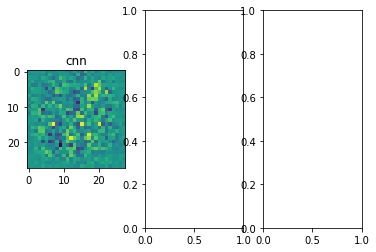

In [9]:
figure, axes = plt.subplots(1, 3)
a_type = "guidedgrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    guided_model = GuidedGrad(m, **kwargs)
    grad = guided_model.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## VanillaGrad

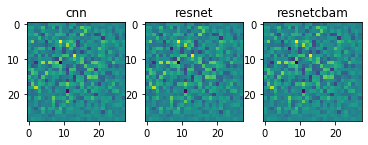

In [7]:
figure, axes = plt.subplots(1, 3)
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])
a_type = "vanillagrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(a_type, m_type, kwargs_packs)
    vanillagrad = VanillaGrad(m, **kwargs)
    grad = guided_model.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## InputGrad

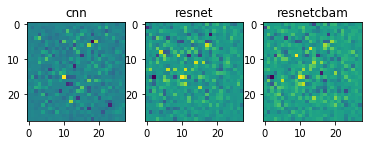

In [8]:
figure, axes = plt.subplots(1, 3)
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])
a_type = "inputgrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(a_type, m_type, kwargs_packs)
    gradinput = InputGrad(m, **kwargs)
    grad = gradinput.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## DeconvNet

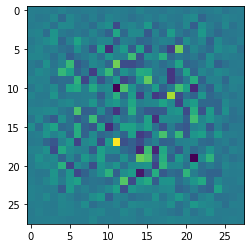

In [9]:
a_type = "deconv"
m_type = "cnn"
kwargs = get_kwargs(a_type, m_type, kwargs_packs)
deconvnet = DeconvNet(model, **kwargs)
deconv = deconvnet.get_attribution(x, targets)
plt.imshow(deconv.squeeze())
plt.show()

## LRP

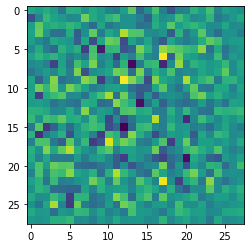

In [10]:
lrp_model = LRP(model)
lrp = lrp_model.get_attribution(x, targets)
plt.imshow(lrp.squeeze())
plt.show()